<a href="https://colab.research.google.com/github/t6nand/mloptimization/blob/master/dnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Neural Network: Handwritten digits classification.

### Dataset: MNIST

Import relevant packages and initialize plot formatting.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 7
plt.rcParams['lines.markersize'] = 4
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

Methods for one-hot encoding and decoding

In [0]:
# Define function to one-hot encode the labels
def one_hot(a, num_classes=10):
  encoded = np.zeros((len(a), num_classes))
  for idx, val in enumerate(a):
      encoded[idx][val] = 1
  return encoded


# Function to convert on-hot encoded array to integer
def onehot_to_int(v):
    return np.argmax(v)

Import the dataset. Training data consists of 60,000 images of size 28x28 pixels. We will divide the training dataset into two parts i.e. training set of 50,000 images and validation set of 10,000 images. Per epoch, the validation set will be randomly chosen for this purpose. 



In [3]:
# Function to load data set based on file prefix as available in the dataset.
def load_dataset(prefix):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile(prefix + '-images-idx3-ubyte', dtype = 'ubyte')
    magicBytes, nImages, width, height = np.frombuffer(data[:nMetaDataBytes].tobytes(), intType)
    data = data[nMetaDataBytes:].astype(dtype = 'float32').reshape([ nImages, width, height ])

    labels = np.fromfile(prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte')[2 * intType.itemsize:]
    return data, labels

# Load training data
train_data, train_labels = load_dataset("train")

# Standardize Training data after flatteining pixel dimensions
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1] * train_data.shape[2])
train_data = ( train_data - np.mean(train_data) ) / (np.std(train_data))

# One-hot encode training labels
train_labels = one_hot(train_labels, 10)

print("Training data- {}: Training Labels: {}".format(train_data.shape, train_labels.shape))

# Load test data
test_data, test_labels = load_dataset("t10k")

# Standardize test data after flattening pixel dimensions
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1] * test_data.shape[2])
test_data = ( test_data - np.mean(test_data) ) / (np.std(test_data))

# One-hot encode testing labels
test_labels = one_hot(test_labels, 10)

print("Testing data- {}: Testing Labels: {}".format(test_data.shape, test_labels.shape))

Training data- (60000, 784): Training Labels: (60000, 10)
Testing data- (10000, 784): Testing Labels: (10000, 10)


Define a class for implementing a neural network with following specifications:

1. $\#$ of input neurons: 784
2. $\#$ of output neurons: 10
3. $\#$ of hideen layers: 1
4. $\#$ of hidden layer neurons: 300
5. Learning algorithm: Mini batch Stochastic Gradient Method
6. Minibatch size: 1000
7. Loss Function: Cross Entropy loss function.

In [0]:
class Nnet:
    def __init__(self, layers,  mini_batch_size, weight_regularization_flag):
      self.layers = layers
      self.L = len(layers) - 1
      self.W, self.b = self.init_Wb()
      self.mini_batch_size = mini_batch_size
      self.small_num = 1e-7 # To prevent underflow errors
      self.lamda = 0
      if weight_regularization_flag:
        self.lamda = 0.0001

    # Activation function to be used by Neural network hidden layers
    def sigmoid(self, x):
        return 1/(1+np.exp(-x + self.small_num))
        
    # Define derivative of the activation function being used.
    def d_sigmoid(self, x):
      return self.sigmoid(x) * (1 - self.sigmoid(x))

    # Activation function used by the output layer of neural network
    def softmax(self, x):
        return np.exp(x + self.small_num) / np.sum(np.exp(x + self.small_num), axis=0)
        
    # Define cross entropy loss funstion
    def cross_entropy_loss(self, Y, Y_hat):
        L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
        m = Y.shape[1]
        L = -(1/m) * L_sum
        return L    

    # Initializing model parameters. Weights are sampled from standard normal
    # distribution and biases are set to zero.    
    def init_Wb(self):
        W, b = {}, {} 
        mu = 0        
        sigma = 1
        for i in range(1,self.L+1):
            W[i] = np.random.normal(mu,sigma,(self.layers[i],self.layers[i-1]))
            b[i] = np.zeros((self.layers[i],1)) # Biases initialised zero
        return W, b
    
    # Method to implement Forward Propogation
    def forward_pass(self, x):
        a, z = {}, {}
        a[0] = x # No activation at the input layer
        L = self.L
        for i in range(1,L):
            # Hidden layers with sigmoid activation

            # Standardize mini batch data to prevent exp overflow errors
            # a_norm = (a[i-1] - np.mean(a[i-1])) / np.std(a[i-1])
            
            z[i] = np.matmul(self.W[i], a[i-1]) + self.b[i]
            a[i] = self.sigmoid(z[i]) 
        
        # Output layer with softmax activation
        z[L] = self.W[L].dot(a[L-1]) + self.b[L]  
        a[L] = self.softmax(z[L]) 

        return a,z 
      
    # Method to implement Back Propogation 
    def backward_pass(self, x, y):

      a,z = self.forward_pass(x)
      L = self.L

      # Partial derivative of cross entropy loss function w.r.t z
      dLdZ = {L: (a[L] - y)} # for softmax layer error is A[output_layer] - Y[Ground Truth]
      for l in range(L-1,0,-1):
          dLdZ[l] = np.matmul(self.W[l+1].T, (dLdZ[l+1])) * self.d_sigmoid(z[l])
 
      db = {}
      for l in range(1,L+1):
          db[l] = (1. / self.mini_batch_size) * np.sum(dLdZ[l], axis=1, keepdims=True)

      dW = {}
      for l in range(1,L+1):
          dW[l] = (1. / self.mini_batch_size) * np.matmul(dLdZ[l], (a[l-1].T))
      
      # return gradients
      return dW, db
    
    # Stochastic Gradient Method Learning with mini batch
    def mini_batch_gradient_learn(self, num_epochs, learn_rate, x, y, 
                  val_size=10000):
      
      train_loss = np.zeros(num_epochs)
      train_acc = np.zeros(num_epochs)
      validation_loss = np.zeros(num_epochs)
      validation_acc = np.zeros(num_epochs)
      num_samples = x.shape[0]

      # Training Begins below:
      for i in range(num_epochs):
        perm = np.random.permutation(x.shape[0])
        x = x[perm]
        y = y[perm]
        training_idx = np.random.randint(x.shape[0], size=num_samples - val_size)
        validation_idx = np.random.randint(x.shape[0], size=val_size)
        training_x, training_y = x[training_idx, :], y[training_idx, :]
        validation_x, validation_y = x[validation_idx, :], y[validation_idx, :]

        # Mini batch SGM:
        for itr in range(0, training_x.shape[0], self.mini_batch_size):
          x_mini = training_x[itr:itr+self.mini_batch_size].T
          y_mini = training_y[itr:itr+self.mini_batch_size].T
          dW, db = self.backward_pass(x_mini, y_mini)  
          for l in range(1, self.L+1):
              self.W[l] = self.W[l] - learn_rate*dW[l]
              self.b[l] = self.b[l] - learn_rate*db[l]

        # Get the training output after all training samples iterated  
        y_train_hat = self.output(training_x.T) 
        
        # Add panalty to cross entropy loss function if required
        penalty = 0
        if self.lamda != 0:
            L = self.L
            penalty = self.lamda * ((np.linalg.norm(self.W[L]) **2) + (np.linalg.norm(self.W[L-1]) ** 2))
        
        # Evaluate training loss and accuracy after each epoch
        train_loss[i] = self.cross_entropy_loss(training_y.T, y_train_hat) + penalty
        train_acc[i] =  self.accuracy(training_y.T, y_train_hat)
         
        # After each training epoch, test on validation set
        for itr in range(0, validation_x.shape[0], self.mini_batch_size):
          x_mini = validation_x[itr:itr+self.mini_batch_size].T
          y_mini = validation_y[itr:itr+self.mini_batch_size].T
          y_mini_hat = self.output(x_mini)
        
        # Evaluate validation loss and accuracy after each epoch
        y_validation_hat = self.output(validation_x.T)
        validation_loss[i] = self.cross_entropy_loss(validation_y.T, y_validation_hat) + penalty
        validation_acc[i] = self.accuracy(validation_y.T, y_validation_hat)

      print("Training Finished!!!")
      return train_loss, train_acc, validation_loss, validation_acc
    
    # Provides outoput from the output layer    
    def output(self, x):
        a_out = None
        a, _ = self.forward_pass(x)
        a_out = a[self.L]
        return a_out 
    
    # Provides the accuracy from model
    def accuracy(self, y_train, y_hat):
      correct = 0.0
      wrong = 0.0
      for i in range(y_train.shape[1]):
        train_op = onehot_to_int(y_train[:, i])
        predicted_op = onehot_to_int(y_hat[:, i])  
        if train_op == predicted_op:
          correct += 1.0
        else:
          wrong += 1.0

      accuracy = correct / (correct + wrong)
      return accuracy

## Train the model without regularized loss function

In [45]:
mini_batch_size = 1000
n_epochs = 30
validation_size = 10000

# Train neural network with unregularized loss function
NN = Nnet((784,300,10), mini_batch_size, False)
train_loss, train_acc, validation_loss, validation_acc   = NN.mini_batch_gradient_learn(n_epochs,
                                                           0.3,
                                                           train_data, 
                                                           train_labels,
                                                           val_size=validation_size)

Training Finished!!!


## Plot the training loss and the validation loss on the same plot.

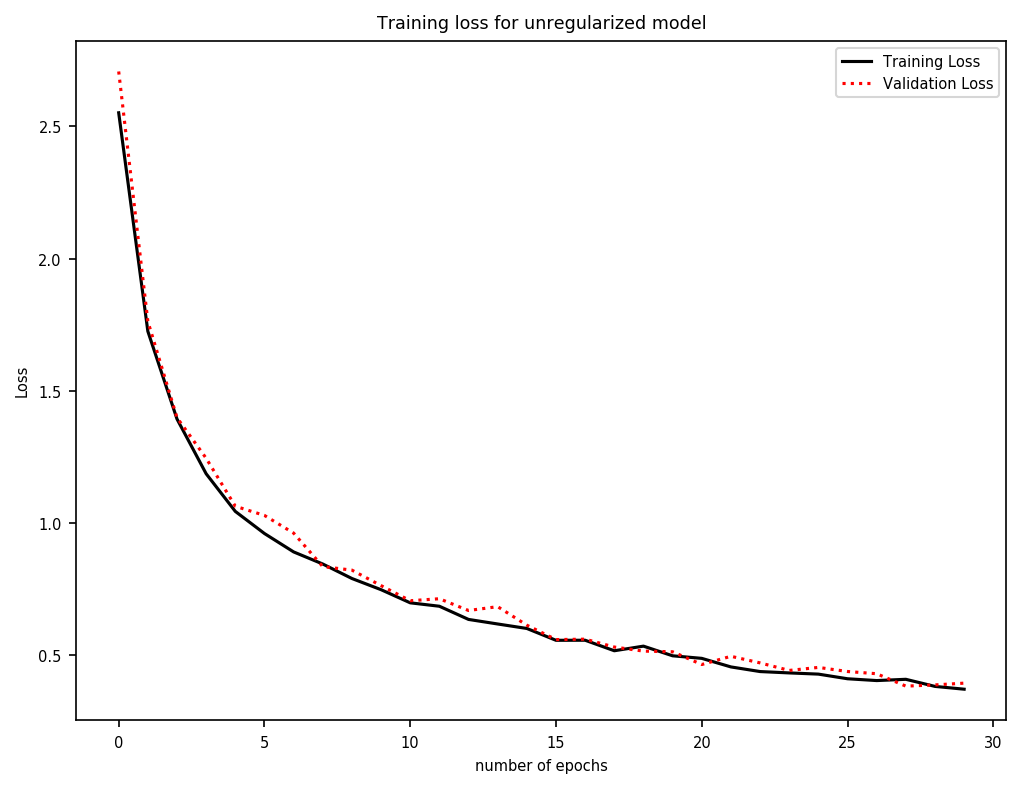

In [46]:
fig1, ax1 = plt.subplots()

ax1.plot(np.arange(n_epochs), train_loss, color='k', label='Training Loss')
ax1.plot(np.arange(n_epochs), validation_loss, ':', color='r', label='Validation Loss')
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.title("Training loss for unregularized model")
plt.legend()
plt.show()

## Plot the classification accuracy results.

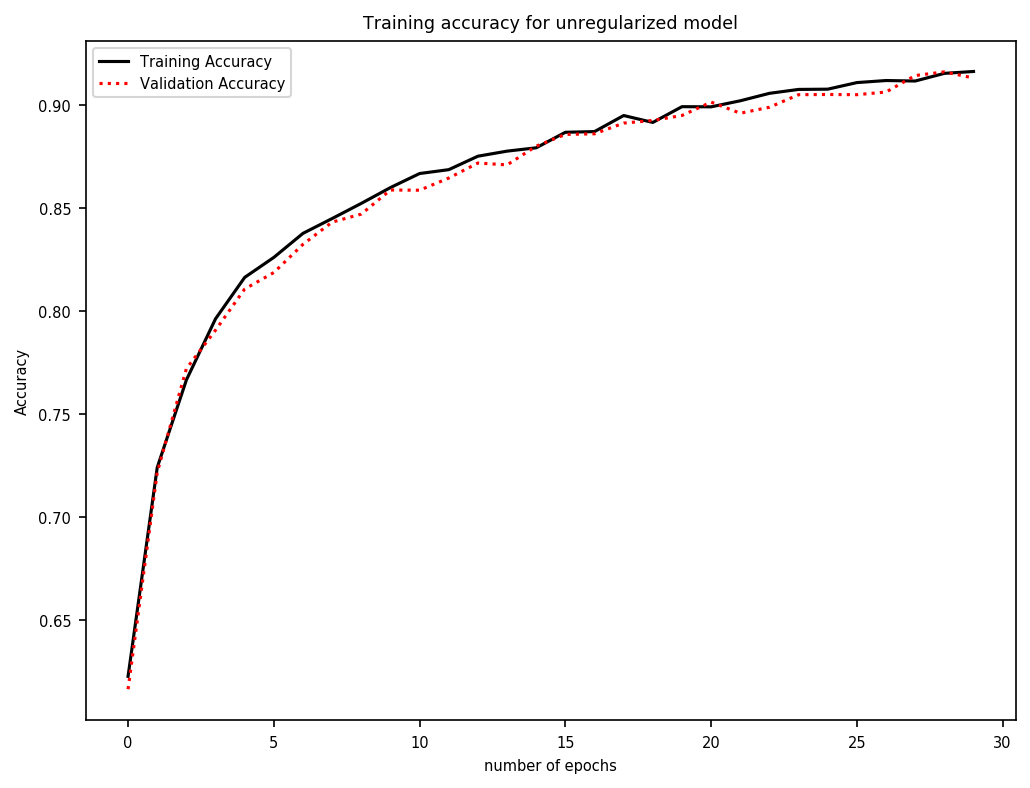

In [47]:
fig2, ax2 = plt.subplots()

ax2.plot(np.arange(n_epochs), train_acc, color='k', label='Training Accuracy')
ax2.plot(np.arange(n_epochs), validation_acc, ':', color='r', label='Validation Accuracy')
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.title("Training accuracy for unregularized model")
plt.legend()
plt.show()

## Test the trained model with non regularized loss funstion

In [48]:
test_output_hat = NN.output(test_data.T)
test_accuracy = NN.accuracy(test_labels, test_output_hat)
print("TEST ACCURACY WITH UNREGULARIZED MODEL: {}".format(test_accuracy))

TEST ACCURACY WITH UNREGULARIZED MODEL: 0.3


## Train the model with regularized loss function

In [49]:
# Train neural network with regularized loss function
NN1 = Nnet((784,300,10), mini_batch_size, True)
train_loss_1, train_acc_1, validation_loss_1, validation_acc_1   = NN1.mini_batch_gradient_learn(n_epochs,
                                                           0.3, 
                                                           train_data, 
                                                           train_labels,
                                                           val_size=validation_size)

Training Finished!!!


## Plot training and validation loss

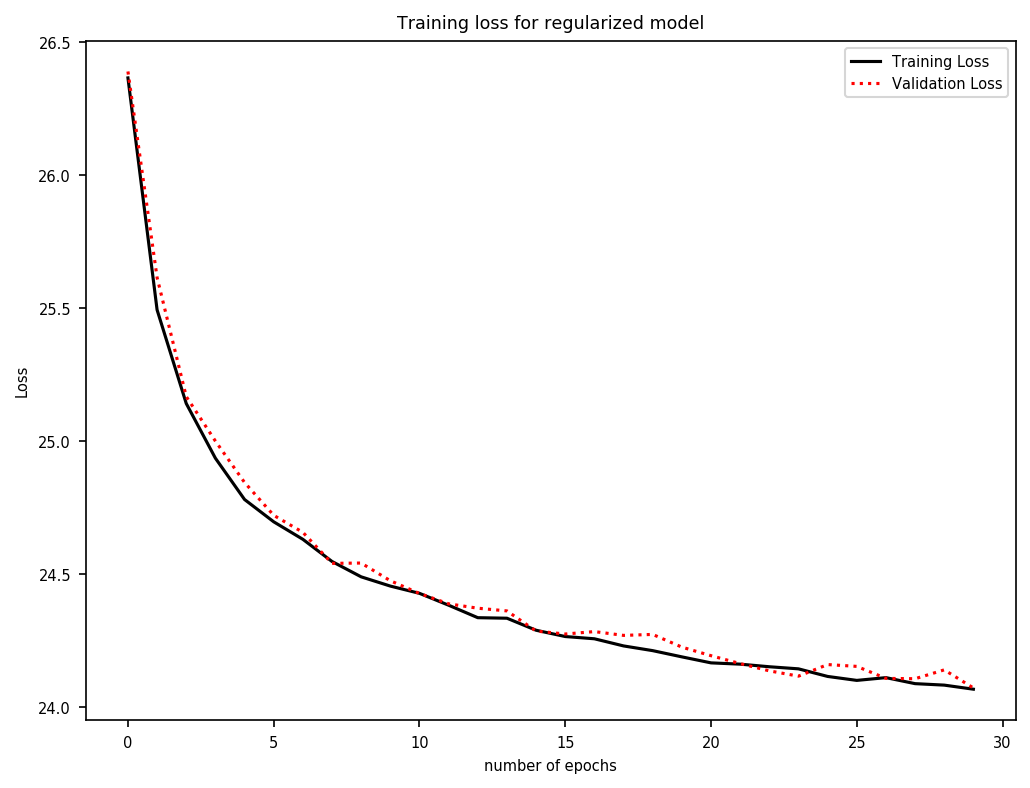

In [50]:
fig3, ax3 = plt.subplots()

ax3.plot(np.arange(n_epochs), train_loss_1, color='k', label='Training Loss')
ax3.plot(np.arange(n_epochs), validation_loss_1, ':', color='r', label='Validation Loss')
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.title("Training loss for regularized model")
plt.legend()
plt.show()

## Plot training and validation accuracy

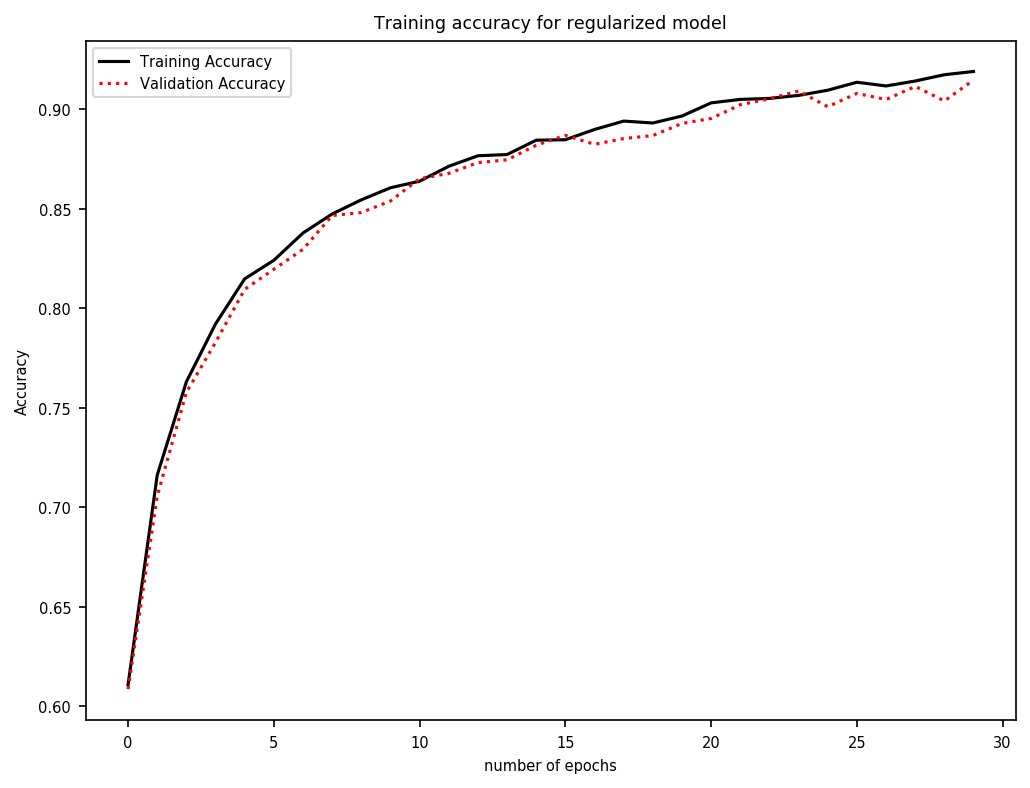

In [52]:
fig4, ax4 = plt.subplots()

ax4.plot(np.arange(n_epochs), train_acc_1, color='k', label='Training Accuracy')
ax4.plot(np.arange(n_epochs), validation_acc_1, ':', color='r', label='Validation Accuracy')
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.title("Training accuracy for regularized model")
plt.legend()
plt.show()

## Test the trained regularized model

In [54]:
test_output_hat_1 = NN1.output(test_data.T)
test_accuracy_1 = NN1.accuracy(test_labels, test_output_hat_1)
print("TEST ACCURACY WITH REGULARIZED MODEL: {}".format(test_accuracy_1))

TEST ACCURACY WITH REGULARIZED MODEL: 0.5
